<span style="font-size:35px; font-family:Arial;">Task-01: Predicting House Prices using Linear Regression Models</span>

<span style="font-size:20px; font-family:Arial;">1. Importing Libraries</span>

In [1]:
import plotly
import plotly.express as px
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn  # Import the sklearn module explicitly
from sklearn.preprocessing import PowerTransformer, StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy  # Import the top-level scipy module
from scipy import stats

# Matplotlib inline configuration
%matplotlib inline 

# Seaborn default settings
sns.set()

<span style="font-size:20px; font-family:Arial;">2. Loading the dataset</span>

In [2]:
# Load the datasets into dataframes
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

<span style="font-size:20px; font-family:Arial;">3. Display the missing values</span>

In [3]:
# Display a summary of missing values for both datasets
train_missing = train_df.isnull().sum()
test_missing = test_df.isnull().sum()

In [4]:
# Identify columns with missing values in train and test datasets
missing_train = train_missing[train_missing > 0].sort_values(ascending=False)
missing_test = test_missing[test_missing > 0].sort_values(ascending=False)

missing_train, missing_test

(PoolQC          1453
 MiscFeature     1406
 Alley           1369
 Fence           1179
 MasVnrType       872
 FireplaceQu      690
 LotFrontage      259
 GarageType        81
 GarageYrBlt       81
 GarageFinish      81
 GarageQual        81
 GarageCond        81
 BsmtFinType2      38
 BsmtExposure      38
 BsmtFinType1      37
 BsmtCond          37
 BsmtQual          37
 MasVnrArea         8
 Electrical         1
 dtype: int64,
 PoolQC          1456
 MiscFeature     1408
 Alley           1352
 Fence           1169
 MasVnrType       894
 FireplaceQu      730
 LotFrontage      227
 GarageCond        78
 GarageYrBlt       78
 GarageQual        78
 GarageFinish      78
 GarageType        76
 BsmtCond          45
 BsmtExposure      44
 BsmtQual          44
 BsmtFinType1      42
 BsmtFinType2      42
 MasVnrArea        15
 MSZoning           4
 BsmtFullBath       2
 BsmtHalfBath       2
 Functional         2
 Utilities          2
 GarageCars         1
 GarageArea         1
 TotalBsmtSF     

<span style="font-size:20px; font-family:Arial;">4. Handling missing values</span>

In [5]:
# Handling missing values

# For numerical columns: Impute using mean/median/mode based on context
train_df['LotFrontage'] = train_df['LotFrontage'].fillna(train_df['LotFrontage'].median())
test_df['LotFrontage'] = test_df['LotFrontage'].fillna(test_df['LotFrontage'].median())

# Impute numerical columns with mean
numerical_columns_train = train_df.select_dtypes(include=['float64', 'int64']).columns
numerical_columns_test = test_df.select_dtypes(include=['float64', 'int64']).columns

train_df[numerical_columns_train] = train_df[numerical_columns_train].fillna(train_df[numerical_columns_train].mean())
test_df[numerical_columns_test] = test_df[numerical_columns_test].fillna(test_df[numerical_columns_test].mean())

# For categorical columns: Replace missing values with "NA" for significant missingness
columns_with_high_missing = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']

for col in columns_with_high_missing:
    train_df[col] = train_df[col].fillna("NA")
    test_df[col] = test_df[col].fillna("NA")

# For low-missingness categorical columns: Use mode for imputation
low_missing_categorical_train = ['MSZoning', 'Electrical', 'Functional']
low_missing_categorical_test = ['MSZoning', 'Utilities', 'Functional', 'KitchenQual', 'SaleType', 'Exterior1st', 'Exterior2nd']

for col in low_missing_categorical_train:
    train_df[col] = train_df[col].fillna(train_df[col].mode()[0])

for col in low_missing_categorical_test:
    test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

# Confirming no missing values remain
missing_train_after = train_df.isnull().sum().sum()
missing_test_after = test_df.isnull().sum().sum()

missing_train_after, missing_test_after

(1383, 1421)

<span style="font-size:20px; font-family:Arial;">5. Distribution and Countplots for Visualizing numerical and categorical columns </span>

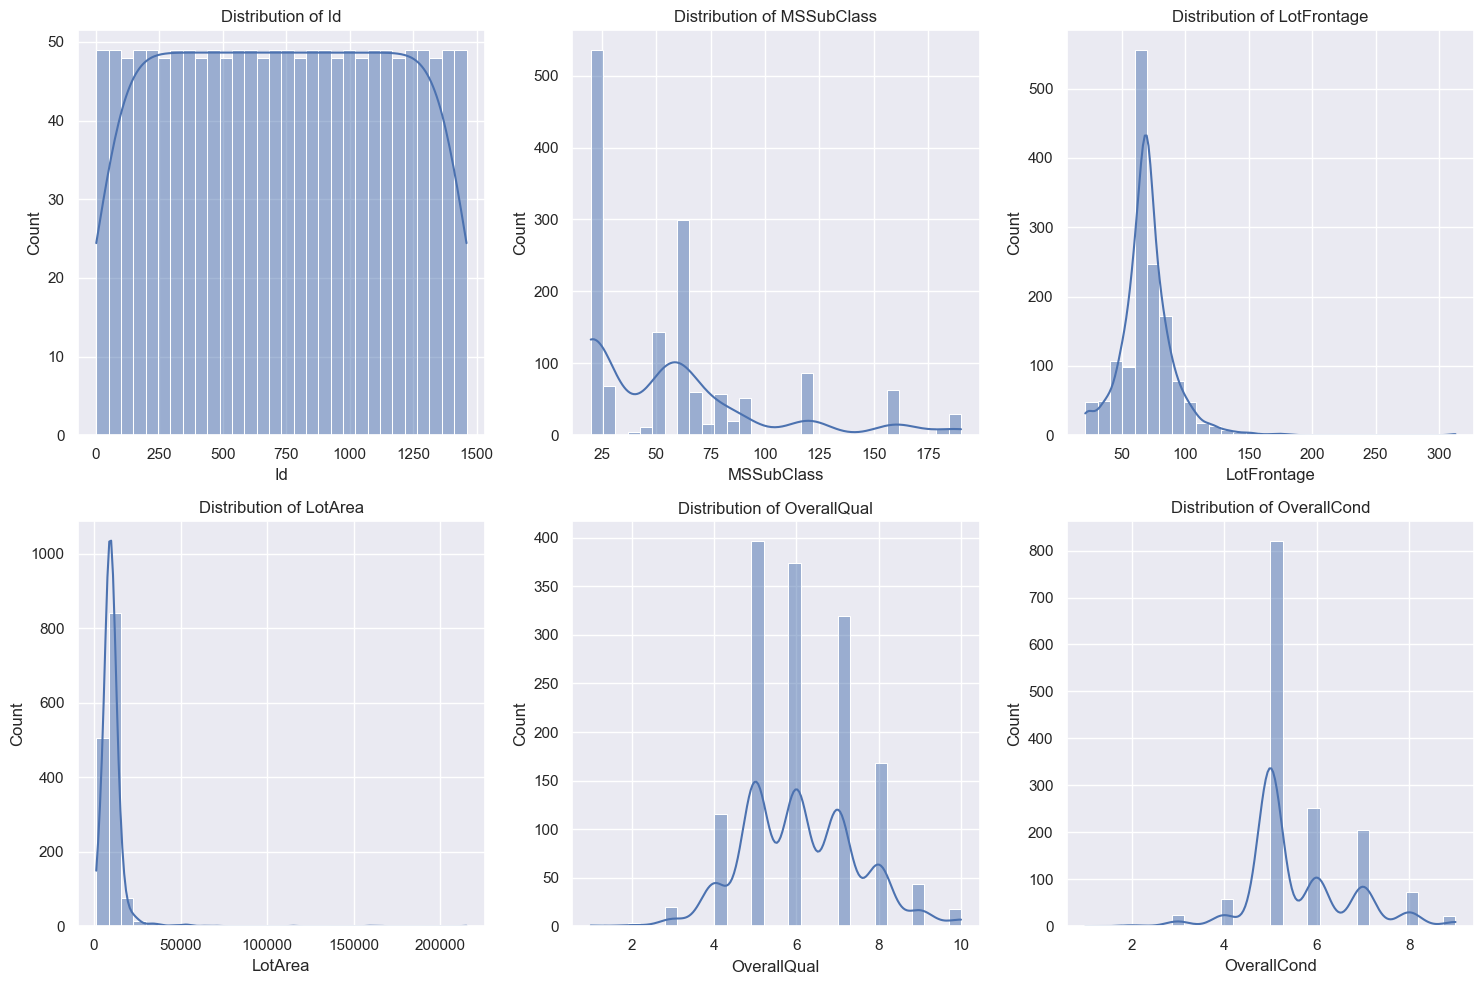

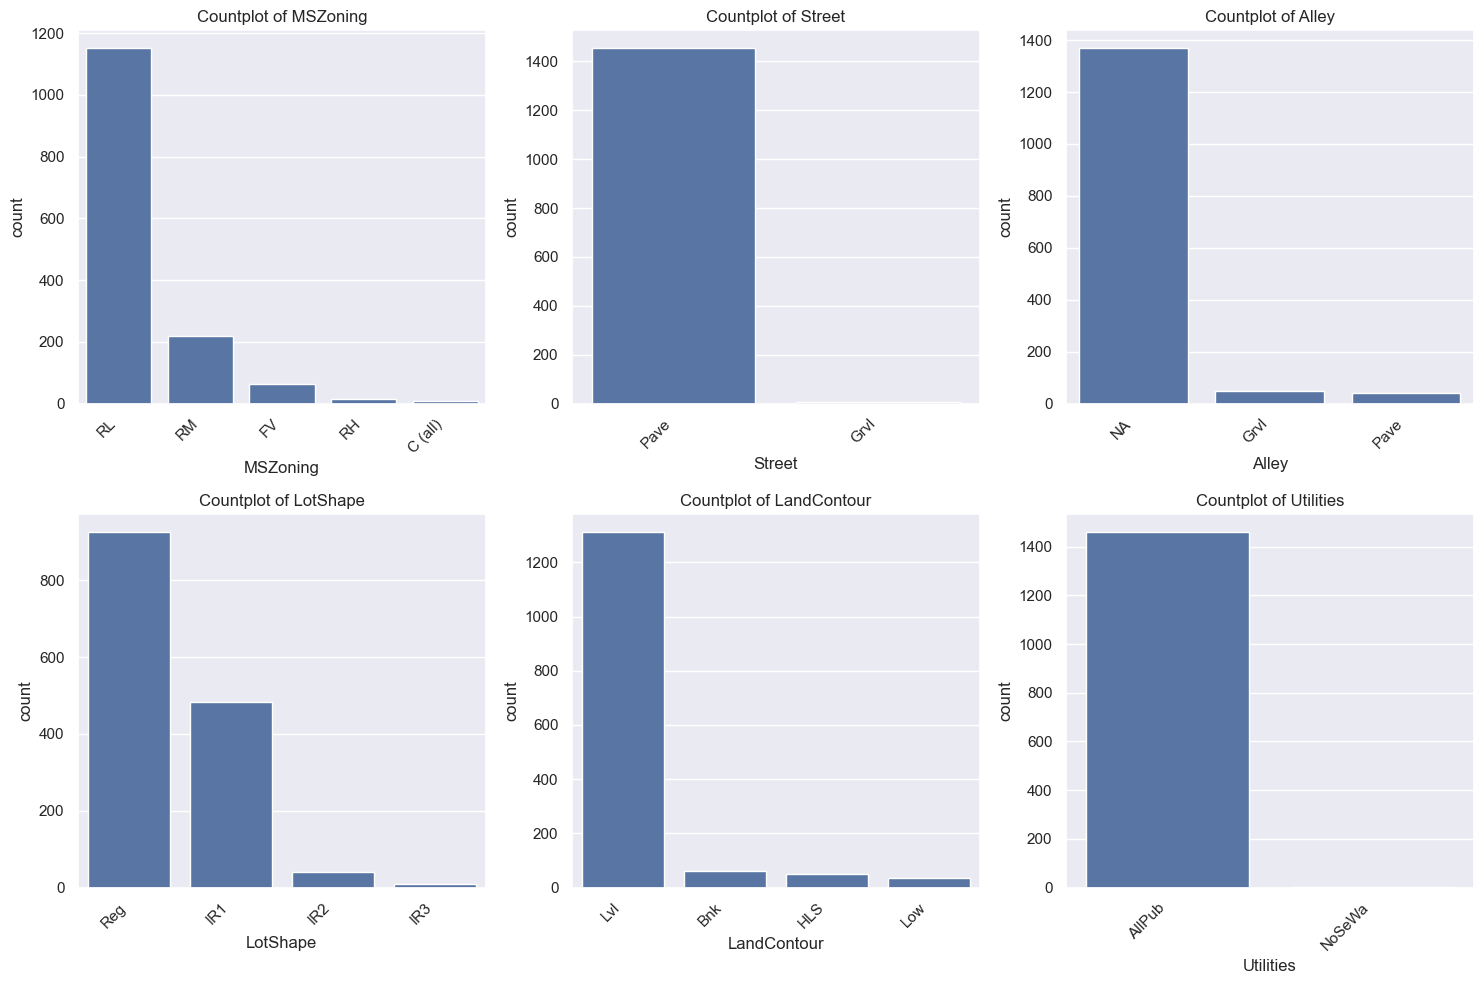

In [6]:
# Visualizing numerical columns: Distribution
numerical_columns = train_df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = train_df.select_dtypes(include=['object']).columns

# Plotting distribution of numerical columns (a sample for better visualization)
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns[:6], start=1):  # Displaying first 6 columns as sample
    plt.subplot(2, 3, i)
    sns.histplot(train_df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

# Visualizing categorical columns: Countplots (a sample for better visualization)
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_columns[:6], start=1):  # Displaying first 6 columns as sample
    plt.subplot(2, 3, i)
    sns.countplot(data=train_df, x=col, order=train_df[col].value_counts().index)
    plt.title(f'Countplot of {col}')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

<span style="font-size:20px; font-family:Arial;">6. Heat Map Correlation</span>

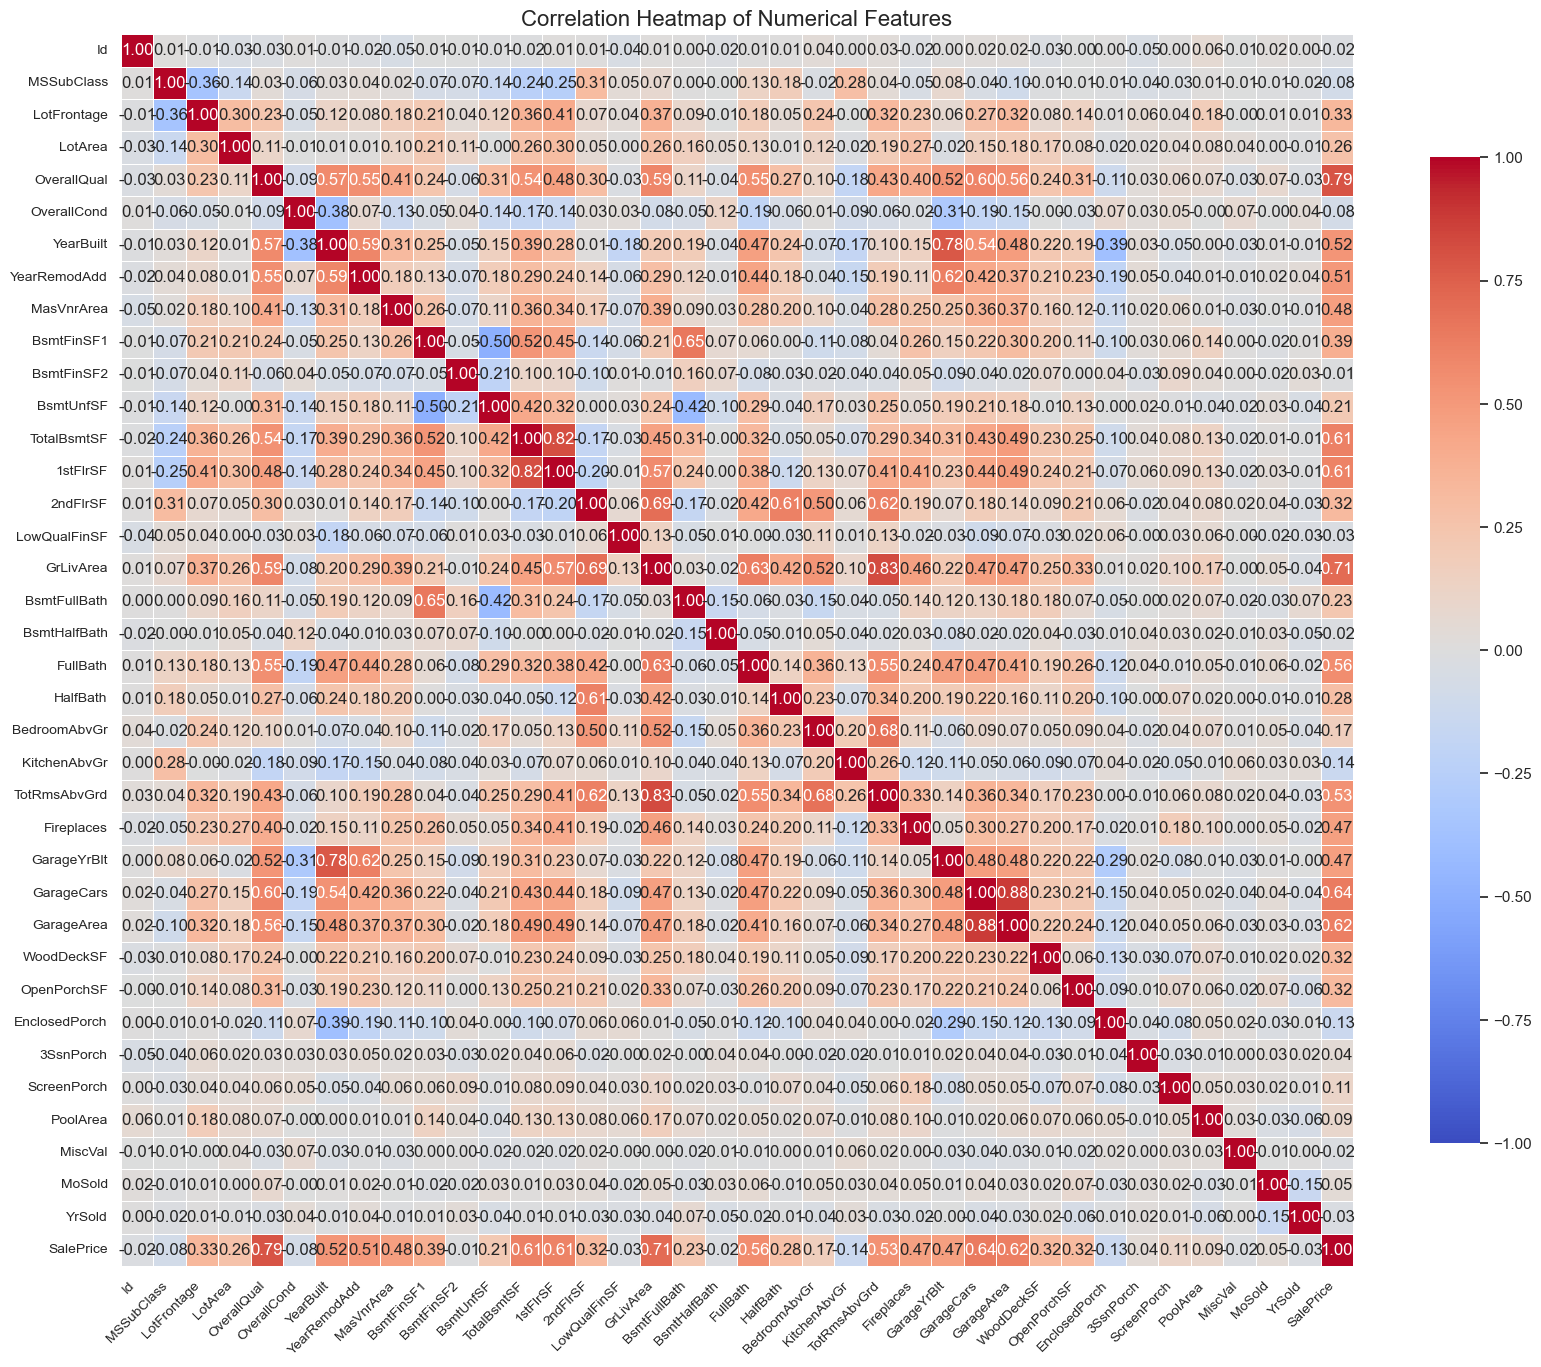

In [7]:
# Select only numerical columns for correlation
numerical_columns_only = train_df.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix for numerical columns
correlation_matrix = numerical_columns_only.corr()
# Adjusting the heatmap for better visibility by making it wider and larger
plt.figure(figsize=(20, 16))  # Increased figure size for better clarity

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            cbar_kws={'shrink': .8}, vmax=1.0, vmin=-1.0, linewidths=0.5)

plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.xticks(fontsize=10, rotation=45, ha='right')  # Adjust font size and angle for x-axis labels
plt.yticks(fontsize=10)  # Adjust font size for y-axis labels
plt.show()

<span style="font-size:20px; font-family:Arial;">7. Selecting Features based on Correlation Threshold</span>

In [8]:
# Threshold for feature selection based on correlation with SalePrice
correlation_threshold = 0.5

# Select features with strong correlation to SalePrice
correlation_with_target = correlation_matrix['SalePrice']
impactful_features = correlation_with_target[correlation_with_target.abs() > correlation_threshold].index.tolist()

# Display the selected features
print("Selected features based on correlation:", impactful_features)

# Optionally drop redundant features by examining pairwise correlations
# (e.g., removing one of two features if they are highly correlated with each other)
redundant_features_threshold = 0.8
pairwise_correlations = correlation_matrix.loc[impactful_features, impactful_features]
upper_triangle = pairwise_correlations.where(
    (pairwise_correlations.abs() < 1) & (pairwise_correlations.abs() > redundant_features_threshold)
)

# Identify redundant features to drop
redundant_features = [col for col in upper_triangle.columns if any(upper_triangle[col] > redundant_features_threshold)]

# Final impactful features after removing redundancy
final_features = [feature for feature in impactful_features if feature not in redundant_features]

print("Final selected features after redundancy removal:", final_features)

Selected features based on correlation: ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'SalePrice']
Final selected features after redundancy removal: ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'FullBath', 'SalePrice']


In [9]:
# Filter only numerical features for correlation and VIF calculation
selected_features = ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'FullBath', 'SalePrice']
numerical_data = train_df[selected_features]

# Compute correlation matrix for numerical features
correlation_with_target = numerical_data.corr()['SalePrice'].sort_values(ascending=False)
print("Correlation with SalePrice:")
print(correlation_with_target)

# Drop features with low variance
selector = VarianceThreshold(threshold=0.01)  # Threshold for low variance
numerical_data_var_filtered = numerical_data.drop(columns=['SalePrice'])  # Exclude target
numerical_data_var_filtered = numerical_data_var_filtered.loc[:, selector.fit(numerical_data_var_filtered).get_support()]

print("\nFeatures remaining after low variance filtering:", numerical_data_var_filtered.columns.tolist())

# Check for multicollinearity using VIF
vif_data = numerical_data_var_filtered.copy()
vif_data['Intercept'] = 1  # Add constant for VIF computation
vif = pd.Series(
    [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])],
    index=vif_data.columns
).sort_values(ascending=False)

print("\nVariance Inflation Factor (VIF):")
print(vif)

# Drop features with high VIF (>10)
final_features = vif[vif < 10].index.tolist()
print("\nFinal features after multicollinearity filtering:", final_features)

Correlation with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
FullBath        0.560664
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

Features remaining after low variance filtering: ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'FullBath']

Variance Inflation Factor (VIF):
Intercept       14546.563650
OverallQual         1.879251
YearBuilt           1.827646
YearRemodAdd        1.741810
FullBath            1.531615
dtype: float64

Final features after multicollinearity filtering: ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'FullBath']


<span style="font-size:20px; font-family:Arial;">8. Splitting the Dataset into Train and Test Sets</span>

In [10]:
# Define the final selected features (excluding target 'SalePrice')
selected_features = ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'FullBath']

# Extract features and target from train.csv
X = train_df[selected_features]
y = train_df['SalePrice']

# Use test.csv as X_test
X_test = test_df[selected_features]

# Split train.csv into training and validation sets (e.g., 80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply scaling/normalization to numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=selected_features, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=selected_features, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=selected_features, index=X_test.index)

# Confirm shapes of prepared datasets
X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape, y_train.shape, y_val.shape

((1168, 4), (292, 4), (1459, 4), (1168,), (292,))

<span style="font-size:20px; font-family:Arial;">9. Developing Linear Regression Model</span>

In [11]:
# Initialize the linear regression model
model = LinearRegression()

# Train the model on X_train and y_train
model.fit(X_train_scaled, y_train)

# Validate the model on X_val and y_val
y_val_pred = model.predict(X_val_scaled)

# Evaluate the model performance using RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae = mean_absolute_error(y_val, y_val_pred)

print(f'Validation RMSE: {rmse}')
print(f'Validation MAE: {mae}')

# Evaluate the model's R² score (goodness of fit) on the training data
train_r2 = model.score(X_train_scaled, y_train)
print(f'R² score on the training data: {train_r2}')

# Evaluate the model's R² score (goodness of fit) on the validation data
val_r2 = model.score(X_val_scaled, y_val)
print(f'R² score on the validation data: {val_r2}')

# Calculate R² score using r2_score for validation set
from sklearn.metrics import r2_score
r2_val = r2_score(y_val, y_val_pred)
print(f'R² score (using r2_score) on the validation data: {r2_val}')

# Step 5: Predict SalePrice for test.csv
y_test_pred = model.predict(X_test_scaled)

# Display some of the predictions
print("Sample predictions on test.csv:", y_test_pred[:10])

Validation RMSE: 50371.45857640326
Validation MAE: 32402.055878306128
R² score on the training data: 0.6466353143216508
R² score on the validation data: 0.6692078315082787
R² score (using r2_score) on the validation data: 0.6692078315082787
Sample predictions on test.csv: [121209.61387183 156160.17222367 156773.27750192 192962.7584244
 262863.87512807 191352.86364758 194411.41899802 192962.7584244
 204094.7577915   88484.88875702]


<span style="font-size:20px; font-family:Arial;">10. Developing Polynomial Regression Model</span>

In [12]:
# Initialize the PolynomialFeatures transformer (degree of polynomial can be adjusted, here set to 2 for quadratic)
poly = PolynomialFeatures(degree=4)

# Transform the training, validation, and test sets to include polynomial features
X_train_poly = poly.fit_transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Initialize the linear regression model
poly_model = LinearRegression()

# Train the polynomial regression model on the transformed training data
poly_model.fit(X_train_poly, y_train)

# Validate the model on X_val_poly and y_val
y_val_pred_poly = poly_model.predict(X_val_poly)

# Evaluate the model performance using RMSE and MAE
rmse_poly = np.sqrt(mean_squared_error(y_val, y_val_pred_poly))
mae_poly = mean_absolute_error(y_val, y_val_pred_poly)

print(f'Polynomial Regression Validation RMSE: {rmse_poly}')
print(f'Polynomial Regression Validation MAE: {mae_poly}')

# Evaluate the R² score on the training data
train_r2_poly = poly_model.score(X_train_poly, y_train)
print(f'Polynomial Regression R² score on the training data: {train_r2_poly}')

# Evaluate the R² score on the validation data
val_r2_poly = poly_model.score(X_val_poly, y_val)
print(f'Polynomial Regression R² score on the validation data: {val_r2_poly}')

# Calculate R² score using r2_score for validation set
r2_val_poly = r2_score(y_val, y_val_pred_poly)
print(f'Polynomial Regression R² score (using r2_score) on the validation data: {r2_val_poly}')

# Step 5: Predict SalePrice for test.csv
y_test_pred_poly = poly_model.predict(X_test_poly)

# Display some of the predictions
print("Sample predictions on test.csv using Polynomial Regression:", y_test_pred_poly[:10])

Polynomial Regression Validation RMSE: 56499.30585675294
Polynomial Regression Validation MAE: 31444.497003424658
Polynomial Regression R² score on the training data: 0.7579266983955526
Polynomial Regression R² score on the validation data: 0.5838284479604219
Polynomial Regression R² score (using r2_score) on the validation data: 0.5838284479604219
Sample predictions on test.csv using Polynomial Regression: [128971.484375 149579.234375 172437.671875 178002.828125 257610.40625
 178935.34375  186055.546875 178002.828125 174672.859375 122069.96875 ]


<span style="font-size:20px; font-family:Arial;">11. using Ridge and Lasso Regression Model</span>

In [13]:
# Initialize Ridge and Lasso regression models (with alpha as a regularization parameter)
ridge_model = Ridge(alpha=1.0)  # You can tune the alpha parameter
lasso_model = Lasso(alpha=0.1)  # You can also tune the alpha parameter

# Train the Ridge model on the transformed training data
ridge_model.fit(X_train_poly, y_train)

# Validate the Ridge model on X_val_poly and y_val
y_val_pred_ridge = ridge_model.predict(X_val_poly)

# Evaluate the Ridge model performance using RMSE and MAE
rmse_ridge = np.sqrt(mean_squared_error(y_val, y_val_pred_ridge))
mae_ridge = mean_absolute_error(y_val, y_val_pred_ridge)

print(f'Ridge Regression Validation RMSE: {rmse_ridge}')
print(f'Ridge Regression Validation MAE: {mae_ridge}')

# Evaluate the R² score on the Ridge model for training data
train_r2_ridge = ridge_model.score(X_train_poly, y_train)
print(f'Ridge Regression R² score on the training data: {train_r2_ridge}')

# Evaluate the R² score on the Ridge model for validation data
val_r2_ridge = ridge_model.score(X_val_poly, y_val)
print(f'Ridge Regression R² score on the validation data: {val_r2_ridge}')

# Calculate R² score using r2_score for Ridge model
r2_val_ridge = r2_score(y_val, y_val_pred_ridge)
print(f'Ridge Regression R² score (using r2_score) on the validation data: {r2_val_ridge}')

# Train the Lasso model on the transformed training data
lasso_model.fit(X_train_poly, y_train)

# Validate the Lasso model on X_val_poly and y_val
y_val_pred_lasso = lasso_model.predict(X_val_poly)

# Evaluate the Lasso model performance using RMSE and MAE
rmse_lasso = np.sqrt(mean_squared_error(y_val, y_val_pred_lasso))
mae_lasso = mean_absolute_error(y_val, y_val_pred_lasso)

print(f'Lasso Regression Validation RMSE: {rmse_lasso}')
print(f'Lasso Regression Validation MAE: {mae_lasso}')

# Evaluate the R² score on the Lasso model for training data
train_r2_lasso = lasso_model.score(X_train_poly, y_train)
print(f'Lasso Regression R² score on the training data: {train_r2_lasso}')

# Evaluate the R² score on the Lasso model for validation data
val_r2_lasso = lasso_model.score(X_val_poly, y_val)
print(f'Lasso Regression R² score on the validation data: {val_r2_lasso}')

# Calculate R² score using r2_score for Lasso model
r2_val_lasso = r2_score(y_val, y_val_pred_lasso)
print(f'Lasso Regression R² score (using r2_score) on the validation data: {r2_val_lasso}')

# Step 5: Predict SalePrice for test.csv using Ridge and Lasso

# Predict using Ridge model
y_test_pred_ridge = ridge_model.predict(X_test_poly)

# Predict using Lasso model
y_test_pred_lasso = lasso_model.predict(X_test_poly)

# Display some of the predictions from both models
print("Sample predictions on test.csv using Ridge Regression:", y_test_pred_ridge[:10])
print("Sample predictions on test.csv using Lasso Regression:", y_test_pred_lasso[:10])

Ridge Regression Validation RMSE: 54388.016819281336
Ridge Regression Validation MAE: 31167.034928371417
Ridge Regression R² score on the training data: 0.7576509294108015
Ridge Regression R² score on the validation data: 0.6143506425107814
Ridge Regression R² score (using r2_score) on the validation data: 0.6143506425107814
Lasso Regression Validation RMSE: 57248.26790990264
Lasso Regression Validation MAE: 31517.519752315413
Lasso Regression R² score on the training data: 0.7577191598595836
Lasso Regression R² score on the validation data: 0.5727216691758057
Lasso Regression R² score (using r2_score) on the validation data: 0.5727216691758057
Sample predictions on test.csv using Ridge Regression: [128761.35047434 149215.34486049 172103.49279924 177955.73998789
 258353.82613813 179052.12810127 186190.57231023 177955.73998789
 176101.10658874 121839.45640999]
Sample predictions on test.csv using Lasso Regression: [128990.74805928 149202.68507367 172628.17199625 177633.02726512
 257535.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.403e+11, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


<span style="font-size:20px; font-family:Arial;">12. Exporting the Dataset based on each Regression Model has been used</span>

In [14]:
# Load the sample submission file to align the structure
sample_submission = pd.read_csv('sample_submission.csv')

# Create a copy of the submission file for each algorithm
# Linear Regression
submission_linear = sample_submission.copy()
submission_linear['SalePrice'] = y_test_pred

# Polynomial Regression
submission_poly = sample_submission.copy()
submission_poly['SalePrice'] = y_test_pred_poly

# Ridge Regression
submission_ridge = sample_submission.copy()
submission_ridge['SalePrice'] = y_test_pred_ridge

# Lasso Regression
submission_lasso = sample_submission.copy()
submission_lasso['SalePrice'] = y_test_pred_lasso

# Save all submission files
submission_linear.to_csv('submission_linear.csv', index=False)
submission_poly.to_csv('submission_poly.csv', index=False)
submission_ridge.to_csv('submission_ridge.csv', index=False)
submission_lasso.to_csv('submission_lasso.csv', index=False)

print("Submission files for Linear, Polynomial, Ridge, and Lasso regressions have been saved.")

Submission files for Linear, Polynomial, Ridge, and Lasso regressions have been saved.


<span style="font-size:20px; font-family:Arial;">13. Comparing The Regression Model Datasets Outputs With The Original One</span>

In [15]:
# Load the provided sample submission file
sample_submission = pd.read_csv('sample_submission.csv')

# Load the generated submission files
submission_linear = pd.read_csv('submission_linear.csv')
submission_poly = pd.read_csv('submission_poly.csv')
submission_ridge = pd.read_csv('submission_ridge.csv')
submission_lasso = pd.read_csv('submission_lasso.csv')

# Define a function to calculate RMSE and MAE
def calculate_metrics(true_values, predicted_values):
    rmse = np.sqrt(np.mean((true_values - predicted_values) ** 2))
    mae = np.mean(np.abs(true_values - predicted_values))
    return rmse, mae

# Compute metrics for each model's submission
rmse_linear, mae_linear = calculate_metrics(sample_submission['SalePrice'], submission_linear['SalePrice'])
rmse_poly, mae_poly = calculate_metrics(sample_submission['SalePrice'], submission_poly['SalePrice'])
rmse_ridge, mae_ridge = calculate_metrics(sample_submission['SalePrice'], submission_ridge['SalePrice'])
rmse_lasso, mae_lasso = calculate_metrics(sample_submission['SalePrice'], submission_lasso['SalePrice'])

# Compile the results
results = {
    "Model": ["Linear", "Polynomial", "Ridge", "Lasso"],
    "RMSE": [rmse_linear, rmse_poly, rmse_ridge, rmse_lasso],
    "MAE": [mae_linear, mae_poly, mae_ridge, mae_lasso]
}

# Convert results to a DataFrame for better readability
results_df = pd.DataFrame(results)
results_df.sort_values(by="RMSE", inplace=True)
results_df

,Model,RMSE,MAE
0,Linear,6.468464e+04,5.428655e+04
3,Lasso,7.687013e+04,5.592556e+04
2,Ridge,7.699540e+04,5.589843e+04
1,Polynomial,2.017996e+14,1.056630e+13


In [16]:
# Print the version of each library
print(f"Plotly: {plotly.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")
print(f"Seaborn: {sns.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")
print(f"Statsmodels: {sm.__version__}")
print(f"SciPy: {scipy.__version__}")  # Corrected for SciPy

Plotly: 5.24.1
NumPy: 1.26.4
Pandas: 2.2.2
Matplotlib: 3.9.2
Seaborn: 0.13.2
Scikit-learn: 1.5.1
Statsmodels: 0.14.2
SciPy: 1.13.1
